In [43]:
import IPython
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import librosa
import sys ; sys.path.append('../')
from model.network_architecture import autoencoder
from tqdm import tqdm
from evaluacion import *

In [2]:
PESOS = '/home/martin/deep-dereverb/model/ckpts/reales/weights.10-0.008.hdf5'
modelo = autoencoder()
modelo.load_weights(PESOS)

2021-08-09 04:52:59.177215: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-09 04:52:59.239034: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-09 04:52:59.239491: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7715GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2021-08-09 04:52:59.239525: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-09 04:52:59.244964: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-09 04:52:59.245034: I tensorflow/stream_executo

In [3]:
reverb_list = get_audio_list('/home/martin/deep-dereverb/data/real/')
clean_list = get_audio_list('/home/martin/deep-dereverb/data/clean/')
reverb_list.sort(); clean_list.sort()

In [4]:
audio_in, fs = librosa.load(reverb_list[0], sr=None)
audio_target, fs = librosa.load(clean_list[0], sr=None)
espectro_in, arr_min, arr_max = gen_stft(audio_in)
espectro_target, _, _ = gen_stft(audio_target)

In [27]:
espectro_out = modelo.predict([espectro_in.reshape(1,256,256)])
espectro_out = espectro_out.reshape(256,256)

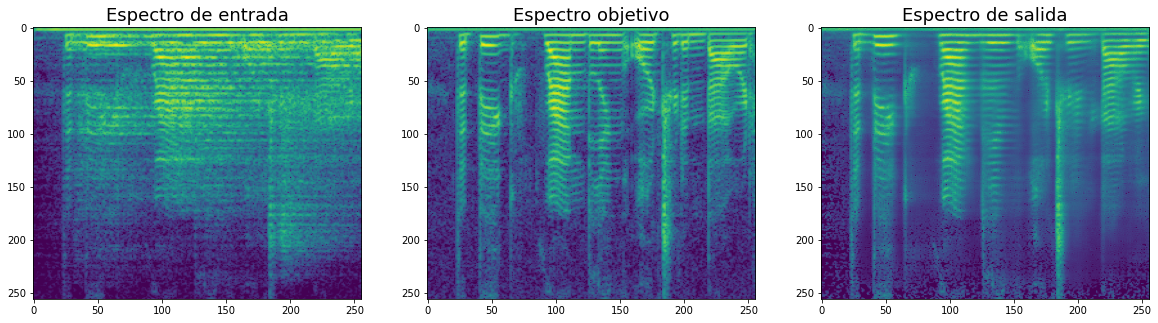

In [33]:
plt.figure(1, figsize=(20,5))
plt.subplot(1,3,1);plt.title('Espectro de entrada', size=18)
plt.imshow(espectro_in, aspect='auto')#;plt.colorbar()
plt.subplot(1,3,2);plt.title('Espectro objetivo', size=18)
plt.imshow(espectro_target, aspect='auto')#;plt.colorbar()
plt.subplot(1,3,3);plt.title('Espectro de salida', size=18)
plt.imshow(espectro_out, aspect='auto')#;plt.colorbar()
plt.savefig('funcionamiento.png')

In [28]:
audio_out = frame_to_raw(espectro_out, arr_min, arr_max)

In [29]:
print('Audio con reverb (entrada)')
IPython.display.display(IPython.display.Audio(audio_in, rate=fs))
print('Audio anecoico (objetivo)')
IPython.display.display(IPython.display.Audio(audio_target, rate=fs))
print('Audio dereverberado (resultado)')
IPython.display.display(IPython.display.Audio(audio_out, rate=fs))

Audio con reverb (entrada)


Audio anecoico (objetivo)


Audio dereverberado (resultado)


# Evaluacion de metricas

In [58]:
clean_list = get_audio_list('/home/martin/deep-dereverb/data/test/clean/')
C4DM_list = get_audio_list('/home/martin/deep-dereverb/data/test/C4DM/')

SRMR_reverb = []
SDR_reverb = []
ESTOI_reverb = []

SRMR_dereverb = []
SDR_dereverb = []
ESTOI_dereverb = []

for clean_path, reverb_path in tqdm(zip(clean_list, C4DM_list), total=len(clean_list)):
    # Leo los audios de partida
    clean, fs = librosa.load(clean_path, sr=None)
    reverb, fs = librosa.load(reverb_path, sr=None)

    # Aplico el modelo
    espectro_in, arr_min, arr_max = gen_stft(reverb)
    espectro_out = modelo.predict([espectro_in.reshape(1,256,256)])
    espectro_out = espectro_out.reshape(256,256)
    dereverb = frame_to_raw(espectro_out, arr_min, arr_max)
    
    # Calculo las metricas para clean-reverb y clean-dereverb
    srmr, sdr, estoi = get_metricas(clean, reverb, fs)
    SRMR_reverb.append(srmr)
    SDR_reverb.append(sdr)
    ESTOI_reverb.append(estoi)
    
    srmr, sdr, estoi = get_metricas(clean, dereverb, fs)
    SRMR_dereverb.append(srmr)
    SDR_dereverb.append(sdr)
    ESTOI_dereverb.append(estoi)
    
    

100%|████████████████████████████████████████████████████████████████████████████████████████| 8262/8262 [3:49:55<00:00,  1.67s/it]


In [59]:

np.save('resultados/SRMR_reverb.npy', SRMR_reverb)
np.save('resultados/SDR_reverb.npy', SDR_reverb)
np.save('resultados/ESTOI_reverb.npy', ESTOI_reverb)

np.save('resultados/SRMR_dereverb.npy', SRMR_dereverb)
np.save('resultados/SDR_dereverb.npy', SDR_dereverb)
np.save('resultados/ESTOI_dereverb.npy', ESTOI_dereverb)


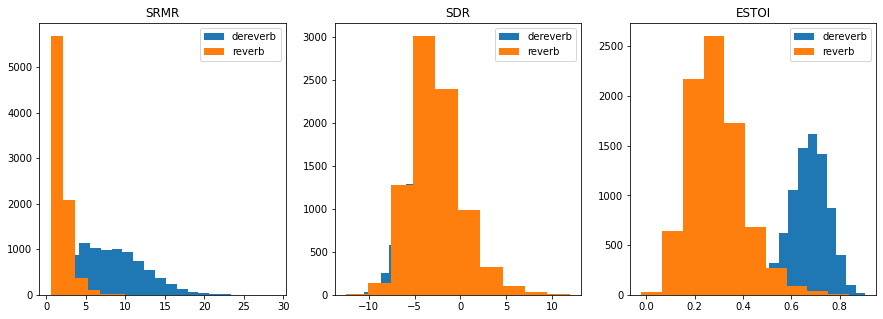

In [65]:
plt.figure(1, figsize=(15,5))
plt.subplot(1,3,1);plt.title('SRMR')
plt.hist(SRMR_dereverb, bins=20, label='dereverb'); plt.hist(SRMR_reverb, label='reverb')
plt.legend()
plt.subplot(1,3,2);plt.title('SDR')
plt.hist(SDR_dereverb, bins=20, label='dereverb'); plt.hist(SDR_reverb, label='reverb')
plt.legend()
plt.subplot(1,3,3);plt.title('ESTOI')
plt.hist(ESTOI_dereverb, bins=20, label='dereverb'); plt.hist(ESTOI_reverb, label='reverb')
plt.legend()